In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import torch
from hydra import compose, initialize
from omegaconf import OmegaConf

from models.diffusion import Diffusion

In [2]:
initialize(config_path="../_configs", version_base="1.2")

hydra.initialize()

In [3]:
cfg = compose(config_name="ddrmpp")

In [4]:
diffusion = Diffusion(**cfg.diffusion)

In [21]:
def get_gw(steps, eta, start_step=1000):
    skip = start_step // steps
    ts = list(range(0, start_step, skip))
    ss = [-1] + list(ts[:-1])
    gw_awd = []
    gw_fwd = []
    alpha = []
    for ti, si in zip(reversed(ts), reversed(ss)):
        t = torch.ones(1).cuda().long() * ti
        s = torch.ones(1).cuda().long() * si
        alpha_t = diffusion.alpha(t)
        alpha_s = diffusion.alpha(s)
        c1 = ((1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)).sqrt() * eta
        c2 = ((1 - alpha_s) - c1 ** 2).sqrt()
        gw_awd.append(alpha_s.sqrt())
        gw_fwd.append(alpha_s.sqrt() - c2 * alpha_t.sqrt() / (1 - alpha_t).sqrt())
        alpha.append(alpha_t)

    gw_awd = torch.cat(list(reversed(gw_awd)), dim=0).cpu()
    gw_fwd = torch.cat(list(reversed(gw_fwd)), dim=0).cpu()
    alpha = torch.cat(list(reversed(alpha)), dim=0).cpu()
    return gw_awd, gw_fwd, alpha, ts, ss

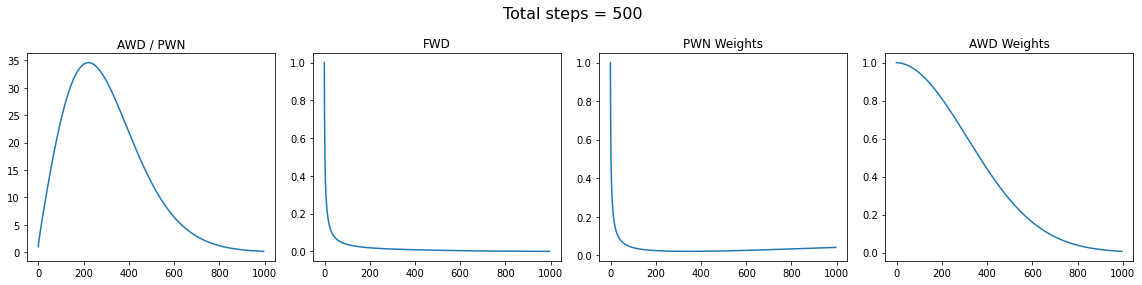

In [58]:
steps = 500
gw_awd, gw_fwd, alpha, ts, ss = get_gw(steps, 1.0, start_step=1000)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(141)
plt.plot(ss, gw_awd / gw_fwd * alpha.sqrt())
plt.title('AWD / PWN')
ax = fig.add_subplot(142)
plt.plot(ss, gw_fwd)
plt.title('FWD')
ax = fig.add_subplot(143)
plt.plot(ss, gw_fwd / alpha.sqrt())
plt.title('PWN Weights')
ax = fig.add_subplot(144)
plt.plot(ss, gw_awd)
plt.title('AWD Weights')
fig.suptitle(f'Total steps = {steps}', fontsize=16)
plt.tight_layout()
plt.savefig(f'{steps}.png', bbox_inches='tight')

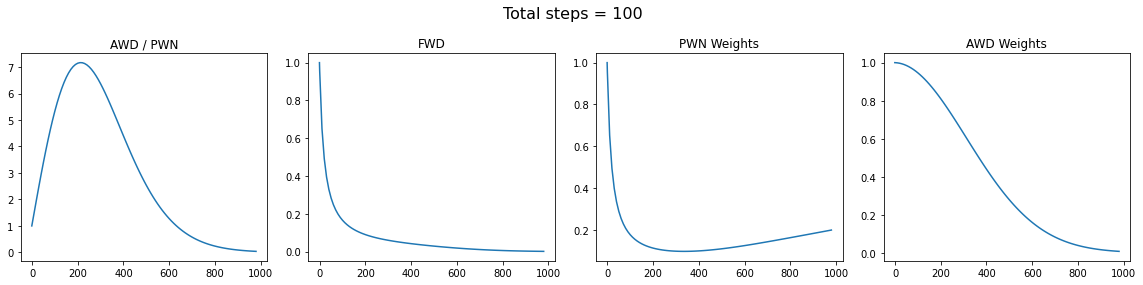

In [56]:
steps = 100
gw_awd, gw_fwd, alpha, ts, ss = get_gw(steps, 1.0, start_step=1000)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(141)
plt.plot(ss, gw_awd / gw_fwd * alpha.sqrt())
plt.title('AWD / PWN')
ax = fig.add_subplot(142)
plt.plot(ss, gw_fwd)
plt.title('FWD')
ax = fig.add_subplot(143)
plt.plot(ss, gw_fwd / alpha.sqrt())
plt.title('PWN Weights')
ax = fig.add_subplot(144)
plt.plot(ss, gw_awd)
plt.title('AWD Weights')
fig.suptitle(f'Total steps = {steps}', fontsize=16)
plt.tight_layout()
plt.savefig(f'{steps}.png', bbox_inches='tight')

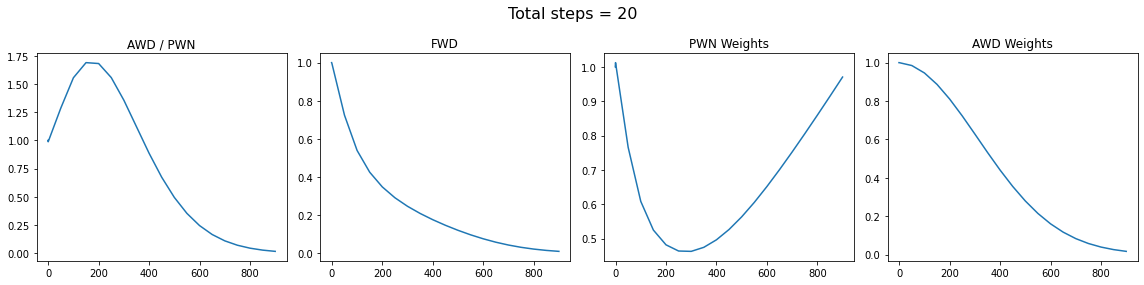

In [57]:
steps = 20
gw_awd, gw_fwd, alpha, ts, ss = get_gw(steps, 1.0, start_step=1000)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(141)
plt.plot(ss, gw_awd / gw_fwd * alpha.sqrt())
plt.title('AWD / PWN')
ax = fig.add_subplot(142)
plt.plot(ss, gw_fwd)
plt.title('FWD')
ax = fig.add_subplot(143)
plt.plot(ss, gw_fwd / alpha.sqrt())
plt.title('PWN Weights')
ax = fig.add_subplot(144)
plt.plot(ss, gw_awd)
plt.title('AWD Weights')
fig.suptitle(f'Total steps = {steps}', fontsize=16)
plt.tight_layout()
plt.savefig(f'{steps}.png', bbox_inches='tight')

In [48]:
b = (alpha / (1 - alpha)).sqrt()
print(b[:-1] - b[1:])

tensor([7.8658e+01, 8.7339e+00, 3.6297e+00, 2.0062e+00, 1.2772e+00, 8.8639e-01,
        6.5225e-01, 5.0080e-01, 3.9718e-01, 3.2313e-01, 2.6837e-01, 2.2674e-01,
        1.9433e-01, 1.6861e-01, 1.4786e-01, 1.3086e-01, 1.1676e-01, 1.0494e-01,
        9.4921e-02, 8.6356e-02, 7.8975e-02, 7.2564e-02, 6.6960e-02, 6.2029e-02,
        5.7665e-02, 5.3781e-02, 5.0308e-02, 4.7187e-02, 4.4368e-02, 4.1813e-02,
        3.9487e-02, 3.7360e-02, 3.5408e-02, 3.3610e-02, 3.1948e-02, 3.0408e-02,
        2.8973e-02, 2.7634e-02, 2.6381e-02, 2.5203e-02, 2.4094e-02, 2.3046e-02,
        2.2054e-02, 2.1112e-02, 2.0216e-02, 1.9361e-02, 1.8544e-02, 1.7761e-02,
        1.7011e-02, 1.6289e-02, 1.5595e-02, 1.4927e-02, 1.4282e-02, 1.3660e-02,
        1.3058e-02, 1.2477e-02, 1.1915e-02, 1.1371e-02, 1.0845e-02, 1.0335e-02,
        9.8428e-03, 9.3663e-03, 8.9056e-03, 8.4603e-03, 8.0303e-03, 7.6152e-03,
        7.2148e-03, 6.8289e-03, 6.4573e-03, 6.0999e-03, 5.7564e-03, 5.4267e-03,
        5.1105e-03, 4.8076e-03, 4.5179e-

In [49]:
b = (alpha[::5] / (1 - alpha[::5])).sqrt()
print(b[:-1] - b[1:])

tensor([9.4305e+01, 2.7597e+00, 1.0059e+00, 5.3384e-01, 3.3819e-01, 2.3746e-01,
        1.7781e-01, 1.3860e-01, 1.1052e-01, 8.8965e-02, 7.1522e-02, 5.6943e-02,
        4.4605e-02, 3.4216e-02, 2.5619e-02, 1.8686e-02, 1.3262e-02, 9.1532e-03,
        6.1431e-03])


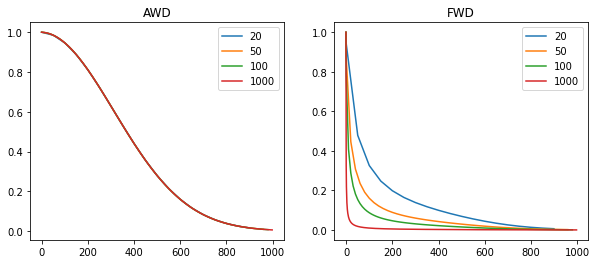

In [123]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
for steps in [20, 50, 100, 1000]:
    gw_awd, gw_fwd, ts, ss = get_gw(steps, 0.0, start_step=1000)
    plt.plot(ss, gw_awd, label=str(steps))
plt.legend()
plt.title('AWD')
ax = fig.add_subplot(122)
for steps in [20, 50, 100, 1000]:
    gw_awd, gw_fwd, ts, ss = get_gw(steps, 0.0, start_step=1000)
    plt.plot(ss, gw_fwd, label=str(steps))
plt.legend()
plt.title('FWD')
plt.savefig('awd_fwd.png')

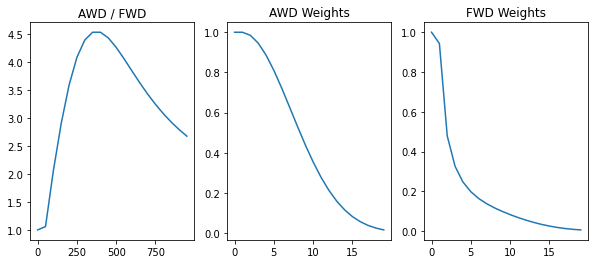

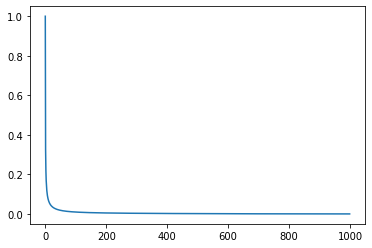

In [77]:
plt.plot(gw_fwd)
plt.title('FWD Weights')

In [9]:
diffusion.alphas[300].sqrt()

tensor(0.6296, device='cuda:0')

In [ ]:
def get_pwd(steps, eta, start_step=1000):
    skip = start_step // steps
    ts = list(range(0, start_step, skip))
    ss = [-1] + list(ts[:-1])
    gw_awd = []
    gw_fwd = []
    alpha = []
    for ti, si in zip(reversed(ts), reversed(ss)):
        t = torch.ones(1).cuda().long() * ti
        s = torch.ones(1).cuda().long() * si
        alpha_t = diffusion.alpha(t)
        alpha_s = diffusion.alpha(s)
        c1 = ((1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)).sqrt() * eta
        c2 = ((1 - alpha_s) - c1 ** 2).sqrt()
        gw_awd.append(alpha_s.sqrt())
        gw_fwd.append(alpha_s.sqrt() - c2 * alpha_t.sqrt() / (1 - alpha_t).sqrt())
        alpha.append(alpha_t)

    gw_awd = torch.cat(list(reversed(gw_awd)), dim=0).cpu()
    gw_fwd = torch.cat(list(reversed(gw_fwd)), dim=0).cpu()
    alpha = torch.cat(list(reversed(alpha)), dim=0).cpu()
    return gw_awd, gw_fwd, alpha, ts, ss